In [1]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
from mltrainer import Trainer, TrainerSettings, ReportTypes
import tomllib
import seaborn as sns
import numpy as np
from torch import Tensor
import math
from typing import List, Tuple, Dict, Any, Union
from src import datasets, metrics
import mltrainer
import mlflow
from src import models
import torch.nn.functional as F


mltrainer.__version__

'0.1.129'

In [3]:
confusion_matrixs = {}

In [16]:

def test_model(model, teststreamer):
    y_true = []
    y_pred = []
    #model = model.to("cpu")

    #testdata = [(x.to(device), y.to(device)) for x, y in teststreamer.stream()]
    testdata = teststreamer.stream()
    for _ in range(len(teststreamer)):
        X, y = next(testdata)

        yhat = model(X)
        yhat = yhat.argmax(dim=1) # we get the one with the highest probability
        y_pred.append(yhat.cpu().tolist())
        y_true.append(y.cpu().tolist())

    yhat = [x for y in y_pred for x in y]
    y = [x for y in y_true for x in y]
    return y, yhat

def plot_confusion_matrix(cfm, model_name):
    # Create the plot using seaborn
    plot = sns.heatmap(cfm, annot=True, fmt=".3f")
    
    # Set the labels for the axes
    plot.set(xlabel="Predicted", ylabel="Target")
    
    # Save the plot to a file with the model name in the filename
    plt.savefig(f"{model_name}_confusion_matrix.png", bbox_inches="tight")
    
    # Optionally, display the plot
    plt.show()

# difference between test and train
def calculate_difference(train_scores_str, test_scores_str):
    # Remove the brackets and split the string by spaces
    str_list = test_scores_str.strip('[]').split()

    # Convert each element to a float
    test_scores_str = [float(num) for num in str_list]

    test_scores = [float(x) for x in test_scores_str]
    train_scores = [float(x) for x in train_scores_str]
    difference = [str(np.round(test - train, 3)) for test, train in zip(test_scores, train_scores)]
    print(f'train loss average:{np.round(np.mean(test_scores), 3)}')
    print(f'test loss average:{np.round(np.mean(test_scores), 3)}')

    return difference



In [4]:
def train_model(trainstreamer, teststreamer, config, settings=None, class_weights=None):

    loss_fn = torch.nn.CrossEntropyLoss()

    if class_weights is not None:
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

    with mlflow.start_run():
        optimizer = torch.optim.Adam

        if settings is None:
            # default settings
            settings = TrainerSettings(
                epochs=15,
                metrics=[accuracy, f1micro, f1macro, precision, recall],
                logdir="logs/heart2D",
                train_steps=len(trainstreamer) // 5,
                valid_steps=len(teststreamer) // 5,
                reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
                scheduler_kwargs={"factor": 0.5, "patience": 2},
                earlystop_kwargs={"patience": 8},
            )

        trainer = Trainer(
            model=model,
            settings=settings,
            loss_fn=loss_fn,
            optimizer=optimizer,
            traindataloader=trainstreamer.stream(),
            validdataloader=teststreamer.stream(),
            scheduler=config["scheduler"],
        )

        mlflow.set_tag("model", config["model"])
        mlflow.set_tag("dataset", "heart_big_SMOTE")
        mlflow.log_param("scheduler", str(trainer.scheduler).split(".")[-1])
        mlflow.log_param("earlystop", str(settings.earlystop_kwargs))

        base_config = {
            "hidden": config["hidden"],
            "dropout": config["dropout"],
            "num_classes": config["num_classes"],
            "num_heads": config["num_heads"],
            "num_blocks": config["num_blocks"],
            "shape": config["shape"]
        }
        mlflow.log_params(base_config)
        mlflow.log_param("epochs", settings.epochs)
        mlflow.log_param("shape0", config["shape"])
        mlflow.log_param("optimizer", str(optimizer))
        mlflow.log_params(settings.optimizer_kwargs)
        trainer.loop()



In [5]:
datadir = Path('../data/processed')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

if torch.backends.mps.is_available():
            device = torch.device('mps')
            print('MPS is available')
else:
            device = torch.device('cpu')

{'ptb': 'heart', 'arrhythmia': 'heart_big'}
MPS is available


In [6]:
trainfile = datadir / (config['arrhythmia'] + '_SMOTE_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/processed/heart_big_SMOTE_train.parq'),
 PosixPath('../data/processed/heart_big_test.parq'))

In [12]:
from sklearn.utils.class_weight import compute_class_weight
#calculate class weights
train_df = pd.read_parquet(trainfile)
classes = train_df.target.unique()
class_weights = compute_class_weight('balanced', classes=classes, y=train_df.target)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32) #.to(device)


In [13]:
# 2D dataset with shape = (16, 12)
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)
traindataset, testdataset

(Heartdataset2D (#362355), Heartdataset2D (#21892))

In [14]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(11323, 684)

In [11]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2Dsmote",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs= {"patience": 8},
        device= device
    )

In [ ]:

modelname= "Transformer2DResNetSE"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "hidden": 128,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
   
}
print(config)
model = models.Transformer2DResNetSE(config)
print(model)

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
confusion_matrixs[modelname] = cfm

print(config)
plot_confusion_matrix(cfm)


In [12]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2Dsmote",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs= {"patience": 8},
        device= device
    )
modelname= "Transformer2DResNetWithAttention"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "hidden": 128,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
   
}
print(config)
model = models.Transformer2DResNetWithAttention(config)
print(model)

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm)

{'model': 'Transformer2DResNetWithAttention', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'hidden': 128, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}
Transformer2DResNetWithAttention(
  (conv2d): Conv2d(1, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (resnet_block): ResNetBlock2D(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (projection): Identity()
  )
  (se_block): SEBlock(
    (fc1): Linear(in_features=128, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=128, bias=True)
    (sigmoid): Sigmoid()
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, 

2025-01-26 22:25:03.143 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2Dsmote/20250126-222503
2025-01-26 22:25:03.448 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 2264/2264 [01:28<00:00, 25.71it/s]
2025-01-26 22:26:33.525 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.4002 test 0.3879 metric ['0.8500', '0.8500', '0.6492', '0.8500', '0.8975']
100%|██████████| 2264/2264 [01:29<00:00, 25.33it/s]
2025-01-26 22:28:04.867 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2228 test 0.4023 metric ['0.8614', '0.8614', '0.7140', '0.8614', '0.9095']
2025-01-26 22:28:04.867 | INFO     | mltrainer.trainer:__call__:234 - best loss: 0.3879, current loss 0.4023.Counter 1/8.
100%|██████████| 2264/2264 [01:28<00:00, 25.57it/s]
2025-01-26 22:29:35.391 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.1719 test 0.2390 metric ['0.9138', '0.9138', '0.7

AttributeError: 'dict' object has no attribute 'append'

{'model': 'Transformer2DResNetWithAttention', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'hidden': 128, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}


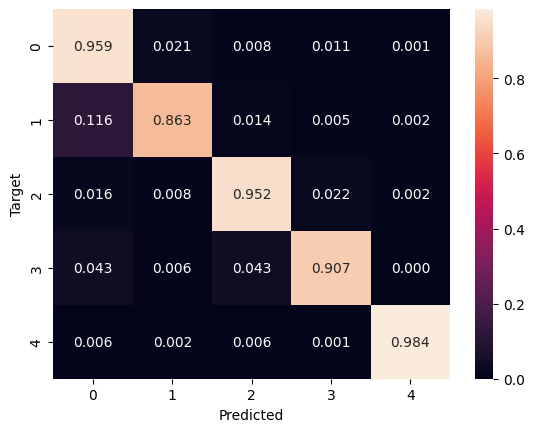

In [13]:
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm)

2025-01-26 22:51:38.242 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2Dsmote/20250126-225138
2025-01-26 22:51:38.242 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


{'model': 'Transformer2DResNet', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'hidden': 128, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}
resnet block
Transformer2DResNet(
  (conv2d): Conv2d(1, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (resnet_block): ResNetBlock2D(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (projection): Identity()
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_blocks): ModuleList(
    (0): TransformerBlock(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128,

100%|██████████| 2264/2264 [00:55<00:00, 41.14it/s]
2025-01-26 22:52:34.934 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.3998 test 0.2385 metric ['0.9249', '0.9249', '0.7481', '0.9249', '0.9060']
100%|██████████| 2264/2264 [00:57<00:00, 39.33it/s]
2025-01-26 22:53:34.197 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2274 test 0.2274 metric ['0.9283', '0.9283', '0.7529', '0.9283', '0.9168']
100%|██████████| 2264/2264 [00:56<00:00, 40.08it/s]
2025-01-26 22:54:32.379 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.1869 test 0.2983 metric ['0.8971', '0.8971', '0.6827', '0.8971', '0.9134']
2025-01-26 22:54:32.379 | INFO     | mltrainer.trainer:__call__:234 - best loss: 0.2274, current loss 0.2983.Counter 1/8.
100%|██████████| 2264/2264 [01:04<00:00, 35.01it/s]
2025-01-26 22:55:38.723 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1590 test 0.4224 metric ['0.8346', '0.8346', '0.6360', '0.8346', '0.8992']
2025-01-26 22:55:38.724 | INFO    

{'model': 'Transformer2DResNet', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'hidden': 128, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}


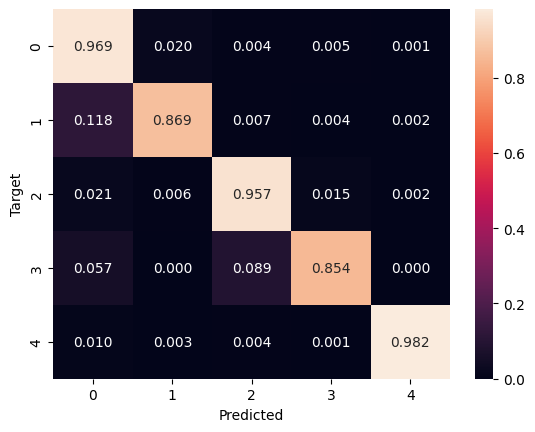

In [14]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2Dsmote",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs= {"patience": 8},
        device= device
    )
modelname= "Transformer2DResNet"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "hidden": 128,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
   
}
print(config)
model = models.Transformer2DResNet(config)
print(model)

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm)

2025-01-27 16:23:05.961 | INFO     | src.models:__init__:38 - Activation map size: 48
2025-01-27 16:23:05.962 | INFO     | src.models:__init__:39 - Input linear: 6144
2025/01/27 16:23:05 INFO mlflow.tracking.fluent: Experiment with name 'CNN2D' does not exist. Creating a new experiment.
2025-01-27 16:23:05.975 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2Dsmote/20250127-162305
2025-01-27 16:23:05.976 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


{'model': 'CNN2D', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 2, 'shape': (16, 12)}


100%|██████████| 2264/2264 [04:42<00:00,  8.00it/s]
2025-01-27 16:27:55.895 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.3138 test 0.2208 metric ['0.9237', '0.9237', '0.7451', '0.9237', '0.9294']
100%|██████████| 2264/2264 [05:14<00:00,  7.20it/s]
2025-01-27 16:33:17.326 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.1141 test 0.2086 metric ['0.9361', '0.9361', '0.7646', '0.9361', '0.9284']
100%|██████████| 2264/2264 [04:47<00:00,  7.88it/s]
2025-01-27 16:38:11.498 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.0810 test 0.1824 metric ['0.9423', '0.9423', '0.7852', '0.9423', '0.9272']
100%|██████████| 2264/2264 [04:48<00:00,  7.84it/s]
2025-01-27 16:43:07.257 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.0646 test 0.1863 metric ['0.9416', '0.9416', '0.7738', '0.9416', '0.9299']
2025-01-27 16:43:07.258 | INFO     | mltrainer.trainer:__call__:234 - best loss: 0.1824, current loss 0.1863.Counter 1/8.
100%|██████████| 2264/2264 [04:45<

{'model': 'CNN2D', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 2, 'shape': (16, 12)}


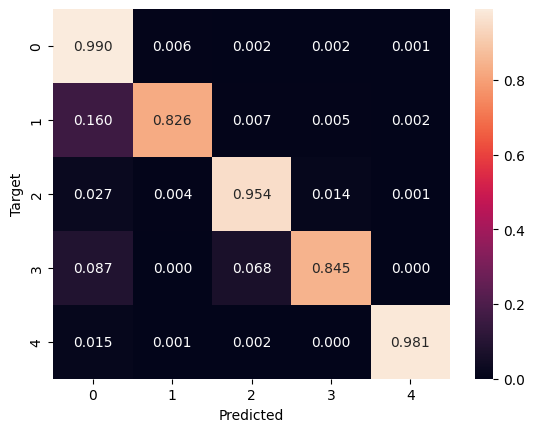

In [22]:
modelname= "CNN2D"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input": 1,
    "hidden": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 2,
    "num_classes": 5,
    "shape": (16, 12),
   
}


print(config)
model = models.CNN(config)
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm, modelname)

In [ ]:
modelname= "CNN2DResNet"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input": 1,
    "hidden": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
   
}


print(config)
model = models.CNN2DResNet(config)
print(model)

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm)

In [ ]:
modelname= "Transformer2D"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input": 1,
    "hidden": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
   
}


print(config)
model = models.Transformer2D(config)
print(model)

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm)

# 1D MODELS

In [8]:
# 1D dataset
traindataset = datasets.HeartDataset1D(trainfile, target="target")
testdataset = datasets.HeartDataset1D(testfile, target="target")

In [9]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(11323, 684)

In [10]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1Dsmote",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs= {"patience": 8},
        device= device
    )

In [9]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 192, 1]), torch.Size([32]))

2025-02-04 11:12:11.127 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1Dsmote/20250204-111211
2025-02-04 11:12:11.127 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


{'model': 'GRU', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 256, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}
{'model': 'GRU', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 256, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}
GRU(
  (rnn): GRU(1, 256, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=256, out_features=5, bias=True)
)


100%|██████████| 2264/2264 [06:55<00:00,  5.45it/s]
2025-02-04 11:19:16.236 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.9335 test 0.5081 metric ['0.8371', '0.8371', '0.5954', '0.8371', '0.8572']
100%|██████████| 2264/2264 [06:57<00:00,  5.42it/s]
2025-02-04 11:26:23.650 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2417 test 0.1921 metric ['0.9377', '0.9377', '0.7659', '0.9377', '0.9235']
100%|██████████| 2264/2264 [07:06<00:00,  5.31it/s]
2025-02-04 11:33:40.386 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.1701 test 0.2285 metric ['0.9175', '0.9175', '0.7318', '0.9175', '0.9168']
2025-02-04 11:33:40.387 | INFO     | mltrainer.trainer:__call__:234 - best loss: 0.1921, current loss 0.2285.Counter 1/8.
100%|██████████| 2264/2264 [07:08<00:00,  5.28it/s]
2025-02-04 11:40:59.128 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1286 test 0.2043 metric ['0.9216', '0.9216', '0.7525', '0.9216', '0.9298']
2025-02-04 11:40:59.129 | INFO    

{'model': 'GRU', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 256, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}


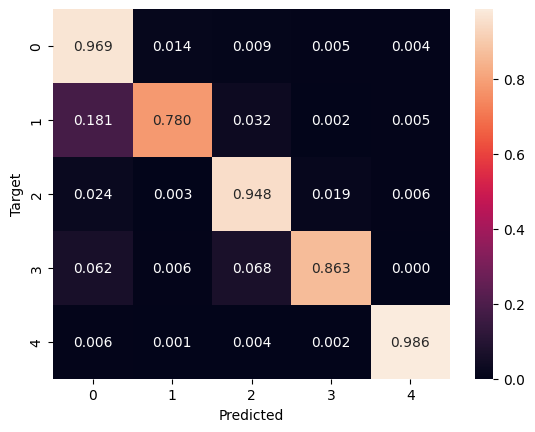

In [12]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1Dsmote",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs= {"patience": 8},
        device= device
    )

modelname= "GRU"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input": 1,
    "hidden": 256,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
   
}


print(config)
model = models.GRU(config)
print(model)

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm, modelname)

In [15]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D_oversampled",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.2, "patience": 2},
        earlystop_kwargs= {"patience": 10},
        device= device
    )
modelname= "CNN1DGRUResNet"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "gru_hidden": 256,
    "hidden": 64,
    "dropout": 0.4,
    "num_layers": 2,
    "num_blocks": 5,
    "num_classes": 5,
    "input_length": 192, 
    "num_heads": 0, 
    "input_size": 1, 
    "shape":(1, 192),
    'traindataset': 'oversampled'
}
if 'smote' in str(trainfile):
        settings.logdir="logs/heart1D_smote"
        config['traindataset'] = 'smote'

print(config)
model = models.CNN1DGRUResNet(config)
print(model)
#summary(model, input_size=(192, 1))
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm, modelname)

2025-02-04 11:59:37.031 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D_oversampled/20250204-115937
2025-02-04 11:59:37.032 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


{'model': 'CNN1DGRUResNet', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'gru_hidden': 256, 'hidden': 64, 'dropout': 0.4, 'num_layers': 2, 'num_blocks': 5, 'num_classes': 5, 'input_length': 192, 'num_heads': 0, 'input_size': 1, 'shape': (1, 192), 'traindataset': 'oversampled'}
CNN1DGRUResNet(
  (convolutions): ModuleList(
    (0): ConvBlock1D(
      (conv): Sequential(
        (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ConvBlock1D(
      (conv): Sequential(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): ResNetBlock1D(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine

100%|██████████| 2264/2264 [13:55<00:00,  2.71it/s]
2025-02-04 12:14:09.540 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.2752 test 0.3086 metric ['0.8913', '0.8913', '0.7317', '0.8913', '0.8982']
100%|██████████| 2264/2264 [2:37:40<00:00,  4.18s/it]
2025-02-04 14:52:27.121 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.1378 test 0.2981 metric ['0.8771', '0.8771', '0.6584', '0.8771', '0.9142']
100%|██████████| 2264/2264 [11:59<00:00,  3.15it/s]
2025-02-04 15:05:03.962 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.1092 test 0.4961 metric ['0.8015', '0.8015', '0.5909', '0.8015', '0.8884']
2025-02-04 15:05:03.963 | INFO     | mltrainer.trainer:__call__:234 - best loss: 0.2981, current loss 0.4961.Counter 1/10.
100%|██████████| 2264/2264 [12:00<00:00,  3.14it/s]
2025-02-04 15:17:40.717 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.0931 test 0.1815 metric ['0.9396', '0.9396', '0.7796', '0.9396', '0.9278']
100%|██████████| 2264/2264 [13:

{'model': 'CNN1DGRUResNet', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'gru_hidden': 256, 'hidden': 64, 'dropout': 0.4, 'num_layers': 2, 'num_blocks': 5, 'num_classes': 5, 'input_length': 192, 'num_heads': 0, 'input_size': 1, 'shape': (1, 192), 'traindataset': 'oversampled'}


TypeError: plot_confusion_matrix() takes 1 positional argument but 2 were given

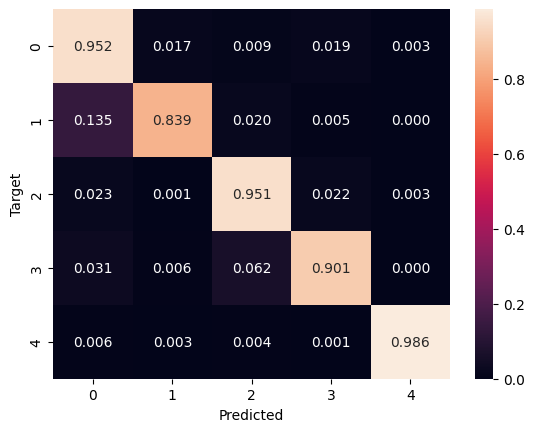

In [17]:
plot_confusion_matrix(cfm, modelname)

2025-01-27 20:26:51.486 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1Dsmote/20250127-202651
2025-01-27 20:26:51.487 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


{'model': 'AttentionGRU', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input_size': 1, 'hidden_size': 128, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'output_size': 5, 'num_heads': 8, 'num_blocks': 1, 'num_classes': 5, 'shape': (16, 12)}
GRUmodel(
  (rnn): GRU(1, 128, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=128, out_features=5, bias=True)
)


100%|██████████| 2264/2264 [02:49<00:00, 13.36it/s]
2025-01-27 20:29:45.131 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.2078 test 0.8574 metric ['0.6206', '0.6206', '0.4449', '0.6206', '0.7198']
100%|██████████| 2264/2264 [05:25<00:00,  6.96it/s]
2025-01-27 20:35:16.337 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.4072 test 0.4861 metric ['0.8504', '0.8504', '0.6240', '0.8504', '0.8964']
100%|██████████| 2264/2264 [09:49<00:00,  3.84it/s]
2025-01-27 20:45:13.701 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2474 test 0.2834 metric ['0.9092', '0.9092', '0.6974', '0.9092', '0.9042']
100%|██████████| 2264/2264 [37:04<00:00,  1.02it/s]
2025-01-27 21:22:21.704 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1940 test 0.2629 metric ['0.9102', '0.9102', '0.7093', '0.9102', '0.9133']
100%|██████████| 2264/2264 [02:41<00:00, 14.05it/s]
2025-01-27 21:25:07.193 | INFO     | mltrainer.trainer:report:191 - Epoch 4 train 0.1589 test 0.3458 met

{'model': 'AttentionGRU', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input_size': 1, 'hidden_size': 128, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'output_size': 5, 'num_heads': 8, 'num_blocks': 1, 'num_classes': 5, 'shape': (16, 12)}


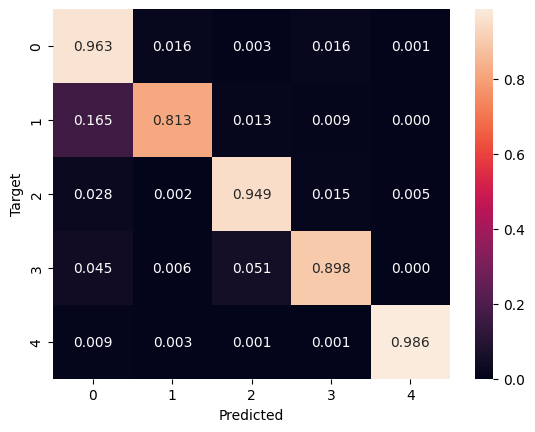

In [37]:
from mltrainer import rnn_models
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1Dsmote",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs= {"patience": 8},
        device= device
    )

modelname= "AttentionGRU"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input_size": 1,
    "hidden_size": 128,
    "hidden": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "output_size": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
}


print(config)
model = rnn_models.GRUmodel(config)
print(model)

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm)

2025-01-27 05:54:03.981 | INFO     | mltrainer.settings:check_path:61 - Created logdir /Users/francesca/code_repo/MADS-exam-25/notebooks/logs/heart1Dsmote
2025-01-27 05:54:03.988 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1Dsmote/20250127-055403
2025-01-27 05:54:03.988 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


{'model': 'Transformer1D', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 2, 'shape': (16, 12)}


100%|██████████| 2264/2264 [16:58<00:00,  2.22it/s]
2025-01-27 06:11:04.391 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.4554 test 0.3493 metric ['0.8938', '0.8938', '0.6671', '0.8938', '0.8878']
100%|██████████| 2264/2264 [32:18<00:00,  1.17it/s]
2025-01-27 06:43:24.570 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2645 test 0.2704 metric ['0.9085', '0.9085', '0.7144', '0.9085', '0.9094']
100%|██████████| 2264/2264 [01:53<00:00, 20.00it/s]
2025-01-27 06:45:20.115 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2168 test 0.2755 metric ['0.9044', '0.9044', '0.7120', '0.9044', '0.9171']
2025-01-27 06:45:20.116 | INFO     | mltrainer.trainer:__call__:234 - best loss: 0.2704, current loss 0.2755.Counter 1/8.
100%|██████████| 2264/2264 [17:16<00:00,  2.19it/s]
2025-01-27 07:02:38.305 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1908 test 0.2221 metric ['0.9221', '0.9221', '0.7376', '0.9221', '0.9238']
100%|██████████| 2264/2264 [18:13<

{'model': 'Transformer1D', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 2, 'shape': (16, 12)}


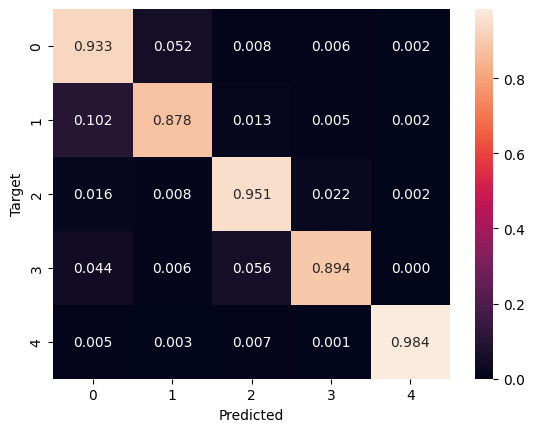

In [20]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1Dsmote",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs= {"patience": 8},
        device= device
    )

modelname= "Transformer1D"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input": 1,
    "hidden": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 2,
    "num_classes": 5,
    "shape": (16, 12),
   
}


print(config)
model = models.Transformer(config)
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm)

2025-01-27 11:04:49.716 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1Dsmote/20250127-110449
2025-01-27 11:04:49.717 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


{'model': 'Transformer1DResnet', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 2, 'shape': (16, 12)}


100%|██████████| 2264/2264 [01:36<00:00, 23.58it/s]
2025-01-27 11:06:27.650 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.4675 test 0.4070 metric ['0.8681', '0.8681', '0.6415', '0.8681', '0.8637']
100%|██████████| 2264/2264 [01:37<00:00, 23.21it/s]
2025-01-27 11:08:06.975 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2683 test 0.3650 metric ['0.8612', '0.8612', '0.6419', '0.8612', '0.8849']
100%|██████████| 2264/2264 [01:36<00:00, 23.47it/s]
2025-01-27 11:09:45.238 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2204 test 0.3480 metric ['0.8596', '0.8596', '0.6426', '0.8596', '0.8919']
100%|██████████| 2264/2264 [01:36<00:00, 23.36it/s]
2025-01-27 11:11:23.967 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1977 test 0.2852 metric ['0.8938', '0.8938', '0.6954', '0.8938', '0.9188']
100%|██████████| 2264/2264 [01:37<00:00, 23.18it/s]
2025-01-27 11:13:03.432 | INFO     | mltrainer.trainer:report:191 - Epoch 4 train 0.1767 test 0.3942 met

{'model': 'Transformer1DResnet', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 2, 'shape': (16, 12)}


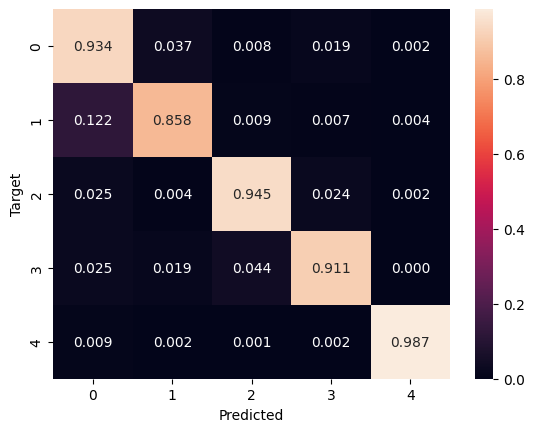

In [21]:

f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1Dsmote",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs= {"patience": 8},
        device= device
    )

modelname= "Transformer1DResnet"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input": 1,
    "hidden": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 2,
    "num_classes": 5,
    "shape": (16, 12),
   
}


print(config)
model = models.Transformer(config)
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm)